In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

There's some `order` data in this directory.  Find it, and read it into a dataframe.

In [3]:
data_path = "data/orders.csv"

df = pd.read_csv(data_path, index_col=0)
df = df.reset_index(drop=True)
df.head(2)

,product_id,state,date,rating,units_sold,price
0,5,ID,2010-02-05,*,6.0,$4.73
1,4,FL,2010-02-07,****,7.0,NaN


<IPython.core.display.Javascript object>

Inspect the data frame with the `.info()` method.  Where do we have nans?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  213 non-null    int64  
 1   state       213 non-null    object 
 2   date        213 non-null    object 
 3   rating      187 non-null    object 
 4   units_sold  187 non-null    float64
 5   price       185 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ KB


<IPython.core.display.Javascript object>

Further inspect the data frame with `.isna()` or `.isnull()`

What percentage of each column is `NaN`?

In [5]:
# What number is NA?
df.isna().sum()

product_id     0
state          0
date           0
rating        26
units_sold    26
price         28
dtype: int64

<IPython.core.display.Javascript object>

In [6]:
# What percentage is NA?
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.131455
dtype: float64

<IPython.core.display.Javascript object>

Convert the price column to numeric

In [7]:
df["price"] = df["price"].str.replace("$", "")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

<IPython.core.display.Javascript object>

Using `pd.to_numeric` with the option `errors="coerce"` can create new `NaN`s. 

Redo the same missing value analysis.

In [8]:
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.131455
dtype: float64

<IPython.core.display.Javascript object>

Convert the ratings column to numeric.

In [9]:
# df["rating"].apply(lambda x: len(str(x)))
# df["rating"].str.strip().str.len()

<IPython.core.display.Javascript object>

In [10]:
ratings_map = {"*": 1, "**": 2, "***": 3, "****": 4, "*****": 5}
df["rating"] = df["rating"].replace(ratings_map)

<IPython.core.display.Javascript object>

In [11]:
df.head()

,product_id,state,date,rating,units_sold,price
0,5,ID,2010-02-05,1.0,6.0,4.73
1,4,FL,2010-02-07,4.0,7.0,NaN
2,1,NY,2010-02-07,1.0,NaN,23.81
3,7,HI,2010-03-12,1.0,4.0,21.78
4,5,NY,2010-04-07,4.0,6.0,4.73


<IPython.core.display.Javascript object>

Convert the date column to a date datatype and sort by it

In [12]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

<IPython.core.display.Javascript object>

In [13]:
# with dt can do a lot of date manipulation
# df["date"].dt.month_name()

<IPython.core.display.Javascript object>

Now let's address the missing values.

In practice, the 2 main ways we might handle NAs are:

* Drop them
* Fill them in with a value
  * Some people didn't mark their height on a survey, maybe we fill in with the average height reported
  * The thermeter broke so we're missing a temperature at time 4, maybe we fill it in with the average of time 3 and time 5 (linear interpolation)


Before dropping we'd like to know why the values are NA because we might be dropping valid data.  For example, you might have seen something like below on a survey:

> 10. Are you a veteran?:  &emsp;&emsp; Yes [&emsp;]&emsp;&emsp;No [&emsp;]
> 
> (only answer the following questions if you answered yes to question 10)

In this case, we should expect non-veterans to have missing values to the veteran only questions.  Other times, missing values aren't that deep and they're just missing.  For example, maybe a survey taker didn't know there was a page 2 so they left it all blank.

In practice it's very important to know how the data was collected and what a missing value indicates.

* Is there any pattern to any of the missingness?

In [14]:
# Rating is not missing at random, missing only for product 0
crosstab = pd.crosstab(df["rating"].isna(), df["product_id"])
crosstab

product_id,0,1,2,3,4,5,6,7,8,9
rating,,,,,,,,,,
False,0,19,22,20,18,17,26,21,24,20
True,26,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [15]:
# (not required) Could have a test point this out
# If p less than 0.05 it indicates not at random
_, p, _, _ = stats.chi2_contingency(crosstab)
p

6.195679897632718e-41

<IPython.core.display.Javascript object>

In [16]:
# Units sold appears to be missing at random based on the categorical variables
crosstab = pd.crosstab(df["units_sold"].isna(), df["state"])
crosstab

state,AZ,CA,FL,GA,HI,ID,NY,OR,TN
units_sold,,,,,,,,,
False,19,29,19,21,15,21,22,16,25
True,1,3,3,3,1,1,7,5,2


<IPython.core.display.Javascript object>

In [17]:
_, p, _, _ = stats.chi2_contingency(crosstab)
p

0.2609828175637216

<IPython.core.display.Javascript object>

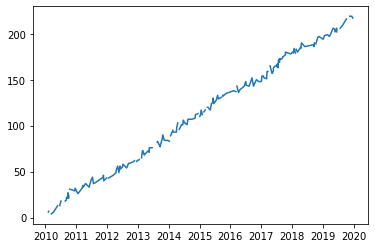

<IPython.core.display.Javascript object>

In [18]:
# We have a time based variable, we might consider investigating
# if missingness is related to time. Here we dont see any big chunks
# missing showing a pattern, but we do see a veryyyy strong correlation
# between date and units sold.
plt.plot(df["date"], df["units_sold"])
plt.show()

We want to move forward with a dataframe that doesn't have any missing values.

* What options do we have?
* Which ones make sense for each column?
    * How do we decide which ones make sense?
    
Once these questions are answered.  Let's apply them until we have no missing values.

In [19]:
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.131455
dtype: float64

<IPython.core.display.Javascript object>

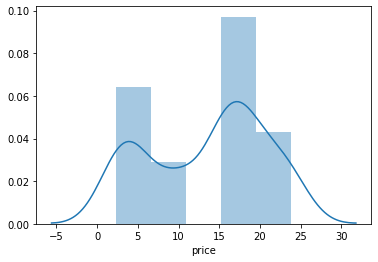

<IPython.core.display.Javascript object>

In [20]:
# For price we didn't see any patterns that might guide how we fill in NAs
# In this case, we dont have a strong reason to drop it, and dropping 13%
# of the data seems a lot without strong reasoning.  Let's fill in with mean or
# median
sns.distplot(df["price"])
plt.show()

In [21]:
df["price"].mean()

13.438108108108109

<IPython.core.display.Javascript object>

In [22]:
df["price"].median()

15.42

<IPython.core.display.Javascript object>

In [23]:
df["price"] = df["price"].fillna(df["price"].mean())
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.000000
dtype: float64

<IPython.core.display.Javascript object>

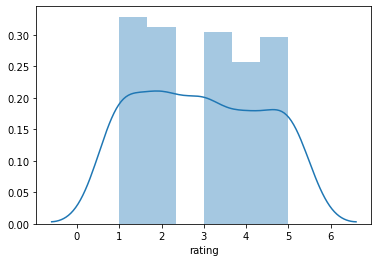

<IPython.core.display.Javascript object>

In [24]:
# Rating was not missing at random, it was only missing for product zero
# Product zero had 0 non-missing values.  Filling in with mean/median might
# mis-represent the rating of product 0.  We might investigate the distribution
# to see if theres a good default rating, but here there's not.  Lets drop.
sns.distplot(df["rating"])
plt.show()

In [25]:
# If dropping, consider the impact.
# Dropping rating NAs loses 12% of data.
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
df = df.dropna(subset=["rating"])
df.isna().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.000000
units_sold    0.112299
price         0.000000
dtype: float64

<IPython.core.display.Javascript object>

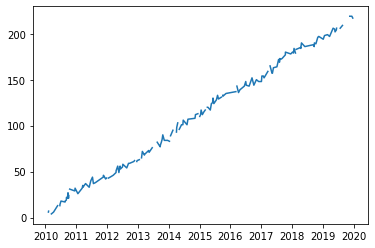

<IPython.core.display.Javascript object>

In [27]:
# Remember theres a strong trend of units sold incresasing over time
plt.plot(df["date"], df["units_sold"])
plt.show()

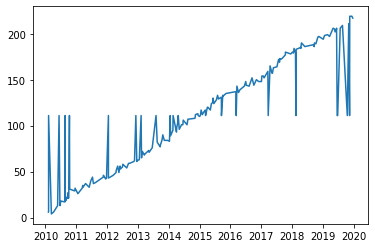

<IPython.core.display.Javascript object>

In [28]:
# if we used median we would really be misrepresenting the true nature of the data:
df_copy = df.copy()
df_copy["units_sold"] = df_copy["units_sold"].fillna(df_copy["units_sold"].median())

plt.plot(df_copy["date"], df_copy["units_sold"])
plt.show()

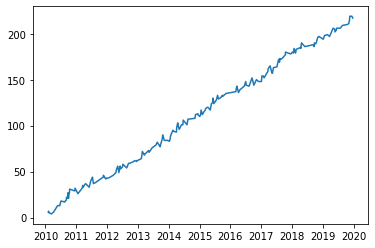

<IPython.core.display.Javascript object>

In [29]:
# we want to preserve the look of this trend with our NA filling
df = df.sort_values("date")
df["units_sold"] = df["units_sold"].interpolate()

plt.plot(df["date"], df["units_sold"])
plt.show()

In [30]:
df.isna().mean()

product_id    0.0
state         0.0
date          0.0
rating        0.0
units_sold    0.0
price         0.0
dtype: float64

<IPython.core.display.Javascript object>